# Notebook 6: Clinical & Biomedical Informatics

**From patient data to clinical insights -- survival analysis, EHR patterns, and clinical endpoints**

Prerequisites: Notebooks 1-5 (sequences, genomics, transcriptomics, protein structure, network biology)

This notebook builds:
1. Clinical data structures (demographics, labs, outcomes)
2. Kaplan-Meier survival analysis
3. Cox proportional hazards model
4. Time-to-event analysis
5. Clinical endpoint analysis
6. EHR data patterns (labs, vitals, medications)
7. Biomarker discovery from clinical data
8. Simulated clinical trial analysis

Estimated runtime: ~3 minutes (all synthetic data, no downloads)

**Key learning outcomes:**
1. Understand clinical data as trajectories through state space -- see [[Trajectory in State Space]]
2. Build and analyze survival curves with censored data
3. Fit Cox models and interpret hazard ratios -- see [[Dose-Response Relationship]]
4. Evaluate biomarker discrimination with ROC analysis -- see [[Adaptive Response]]
5. Design and analyze simulated clinical trials

## Section 0: Setup

We use **lifelines** for survival analysis (Kaplan-Meier, Cox PH), plus the standard
scientific Python stack. lifelines is optional -- manual implementations are provided
as fallback for systems without it installed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

try:
    from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
    from lifelines.statistics import logrank_test
    HAS_LIFELINES = True
    print("lifelines available")
except ImportError:
    HAS_LIFELINES = False
    print("lifelines not installed -- using manual Kaplan-Meier")

print("Ready -- numpy, pandas, scipy, sklearn, matplotlib")

lifelines available
Ready -- numpy, pandas, scipy, sklearn, matplotlib


## Section 1: Clinical Data Structure

Clinical data comes in structured tables: demographics, laboratory results, vital signs,
medications, diagnoses (ICD codes), and outcomes. The challenge is temporal -- events
happen at different times, data is irregularly sampled, and outcomes are often censored
(patient lost to follow-up).

Reference [[Trajectory in State Space]] -- a patient's clinical course is a trajectory
through a high-dimensional state space of lab values, vitals, and symptoms.

Reference [[Context Conditionality]] -- the same lab value means different things depending
on the patient's age, sex, comorbidities, and medications.

In [2]:
np.random.seed(42)
n_patients = 500

# Demographics
ages = np.random.normal(62, 12, n_patients).astype(int)
ages = np.clip(ages, 30, 90)
sex = np.random.choice(['M', 'F'], n_patients, p=[0.55, 0.45])
bmi = np.random.normal(27.5, 5, n_patients)
bmi = np.clip(bmi, 18, 45)

# Disease stage (I-IV)
stage = np.random.choice(['I', 'II', 'III', 'IV'], n_patients, p=[0.2, 0.3, 0.3, 0.2])

# Treatment arm
treatment = np.random.choice(['Standard', 'Experimental'], n_patients)

# Lab values
creatinine = np.random.lognormal(0, 0.3, n_patients)
hemoglobin = np.random.normal(12.5, 2, n_patients)
wbc = np.random.lognormal(2, 0.3, n_patients)

# Biomarker (correlated with outcome)
biomarker = np.random.normal(50, 15, n_patients)
biomarker[stage == 'III'] += 10
biomarker[stage == 'IV'] += 25

# Survival time (influenced by stage, treatment, biomarker)
base_hazard = 0.01
stage_risk = {'I': 0.5, 'II': 1.0, 'III': 2.0, 'IV': 4.0}
treatment_effect = {'Standard': 1.0, 'Experimental': 0.6}

hazard = np.array([base_hazard * stage_risk[s] * treatment_effect[t] * (1 + 0.01 * b)
                    for s, t, b in zip(stage, treatment, biomarker)])
survival_time = np.random.exponential(1.0 / hazard)
survival_time = np.clip(survival_time, 0.1, 60)  # Max 60 months

# Censoring (20% lost to follow-up)
max_followup = 48  # months
censored = survival_time > max_followup
observed_time = np.minimum(survival_time, max_followup)
event = ~censored  # 1 = death observed, 0 = censored

# Create DataFrame
clinical_df = pd.DataFrame({
    'patient_id': [f'PT_{i:04d}' for i in range(n_patients)],
    'age': ages, 'sex': sex, 'bmi': bmi, 'stage': stage,
    'treatment': treatment, 'creatinine': creatinine.round(2),
    'hemoglobin': hemoglobin.round(1), 'wbc': wbc.round(1),
    'biomarker': biomarker.round(1),
    'time_months': observed_time.round(1),
    'event': event.astype(int)
})

print(f"Clinical cohort: {n_patients} patients")
print(f"\nDemographics:")
print(clinical_df[['age', 'sex', 'bmi', 'stage']].describe())
print(f"\nEvents: {event.sum()} deaths, {censored.sum()} censored")
print(f"\nFirst 5 patients:")
print(clinical_df.head())

Clinical cohort: 500 patients

Demographics:
              age         bmi
count  500.000000  500.000000
mean    61.544000   27.883585
std     11.534737    4.857043
min     30.000000   18.000000
25%     53.000000   24.466679
50%     62.000000   27.851200
75%     69.000000   30.994803
max     90.000000   40.398547

Events: 288 deaths, 212 censored

First 5 patients:
  patient_id  age sex        bmi stage     treatment  creatinine  hemoglobin  \
0    PT_0000   67   F  26.664410     I  Experimental        0.82        13.6   
1    PT_0001   60   F  28.233568     I      Standard        0.96        14.4   
2    PT_0002   69   M  33.532545    IV  Experimental        0.79        11.8   
3    PT_0003   80   F  23.415322   III      Standard        0.91        11.3   
4    PT_0004   59   F  29.343367    II      Standard        0.57        10.3   

    wbc  biomarker  time_months  event  
0   4.2       67.7         48.0      0  
1   5.7       40.6         12.7      1  
2   6.5       75.7         4

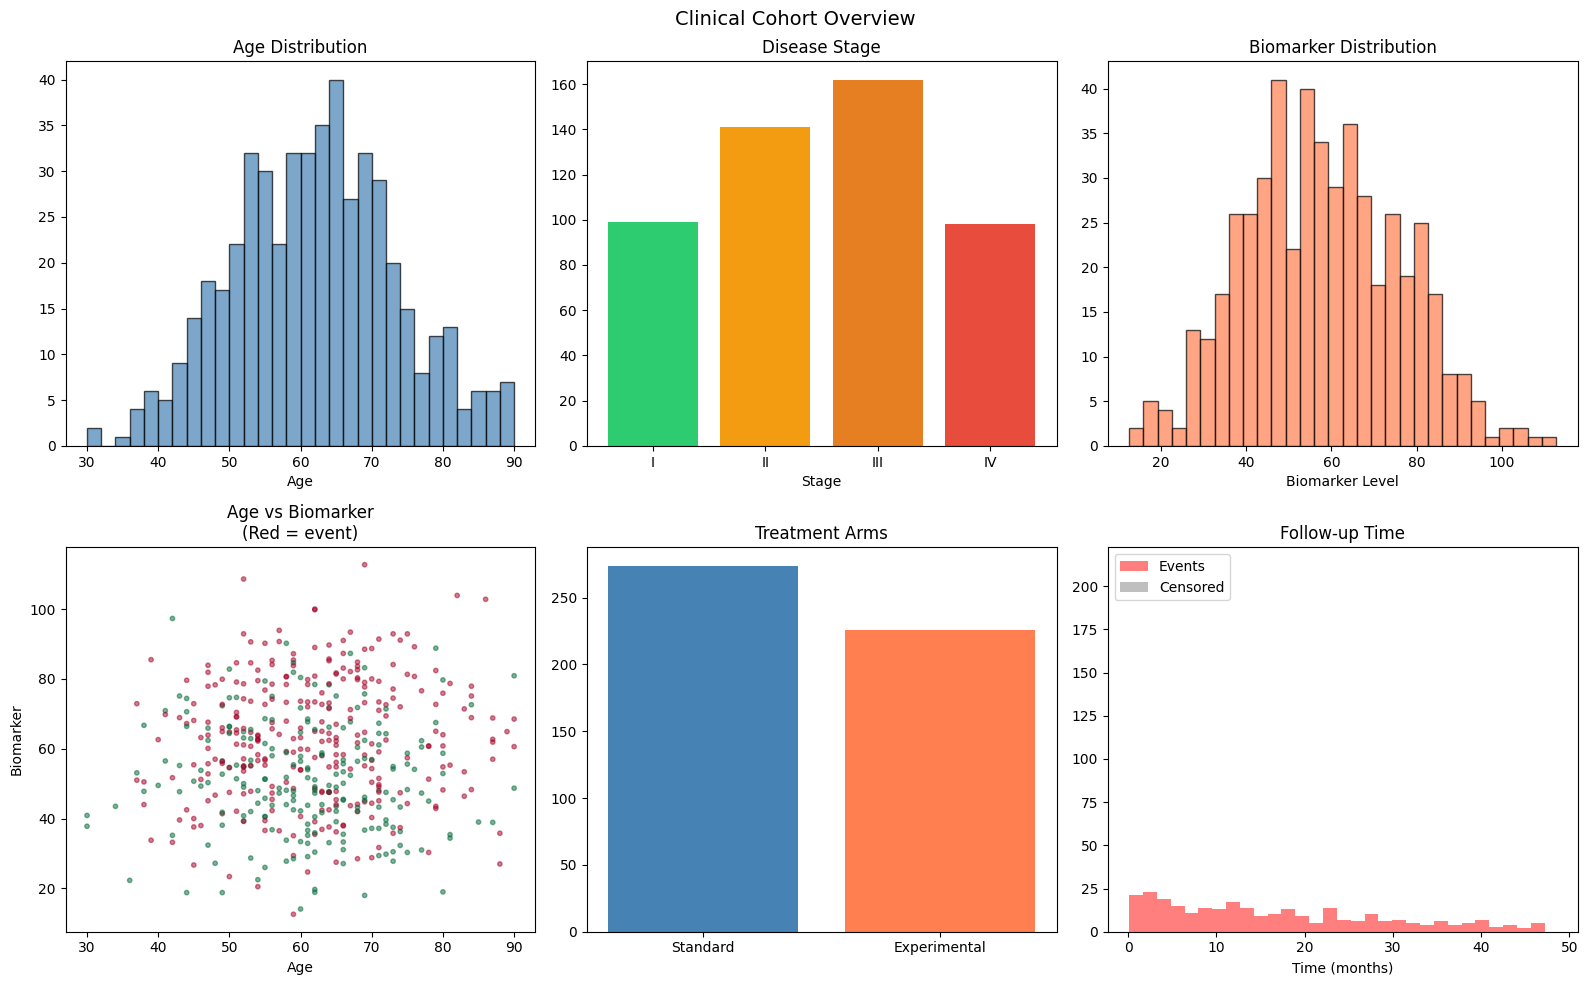

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0,0].hist(clinical_df['age'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].set_xlabel('Age')
axes[0,0].set_title('Age Distribution')

stage_counts = clinical_df['stage'].value_counts().sort_index()
axes[0,1].bar(stage_counts.index, stage_counts.values, color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c'])
axes[0,1].set_xlabel('Stage')
axes[0,1].set_title('Disease Stage')

axes[0,2].hist(clinical_df['biomarker'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0,2].set_xlabel('Biomarker Level')
axes[0,2].set_title('Biomarker Distribution')

axes[1,0].scatter(clinical_df['age'], clinical_df['biomarker'],
                  c=clinical_df['event'], cmap='RdYlGn_r', s=10, alpha=0.5)
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Biomarker')
axes[1,0].set_title('Age vs Biomarker\n(Red = event)')

treatment_counts = clinical_df['treatment'].value_counts()
axes[1,1].bar(treatment_counts.index, treatment_counts.values, color=['steelblue', 'coral'])
axes[1,1].set_title('Treatment Arms')

axes[1,2].hist(clinical_df.loc[clinical_df['event']==1, 'time_months'], bins=30, alpha=0.5, label='Events', color='red')
axes[1,2].hist(clinical_df.loc[clinical_df['event']==0, 'time_months'], bins=30, alpha=0.5, label='Censored', color='gray')
axes[1,2].set_xlabel('Time (months)')
axes[1,2].set_title('Follow-up Time')
axes[1,2].legend()

plt.suptitle('Clinical Cohort Overview', fontsize=14)
plt.tight_layout()
plt.show()

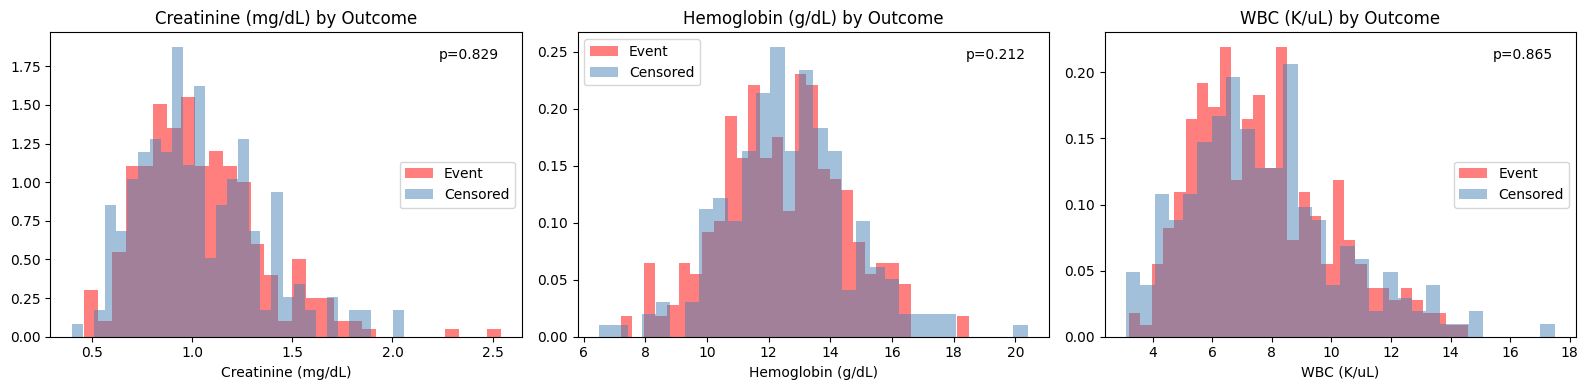

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
labs = ['creatinine', 'hemoglobin', 'wbc']
titles = ['Creatinine (mg/dL)', 'Hemoglobin (g/dL)', 'WBC (K/uL)']

for ax, lab, title in zip(axes, labs, titles):
    event_vals = clinical_df.loc[clinical_df['event']==1, lab]
    censor_vals = clinical_df.loc[clinical_df['event']==0, lab]
    ax.hist(event_vals, bins=30, alpha=0.5, label='Event', color='red', density=True)
    ax.hist(censor_vals, bins=30, alpha=0.5, label='Censored', color='steelblue', density=True)
    ax.set_xlabel(title)
    ax.set_title(f'{title} by Outcome')
    ax.legend()

    # T-test
    t, p = stats.ttest_ind(event_vals, censor_vals)
    ax.text(0.95, 0.95, f'p={p:.3f}', transform=ax.transAxes, ha='right', va='top')

plt.tight_layout()
plt.show()

## Section 2: Kaplan-Meier Survival Analysis

The Kaplan-Meier estimator computes the survival probability over time, accounting for censoring:

$$\hat{S}(t) = \prod_{t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)$$

where $d_i$ = deaths at time $t_i$, $n_i$ = patients at risk at time $t_i$.

Censored patients contribute to the "at risk" count but not to the death count.
This is the key innovation: we use ALL data, even incomplete follow-up.

Reference [[Perturbation-Response-Adaptation]] -- survival analysis measures how
patients respond to the perturbation of disease over time.

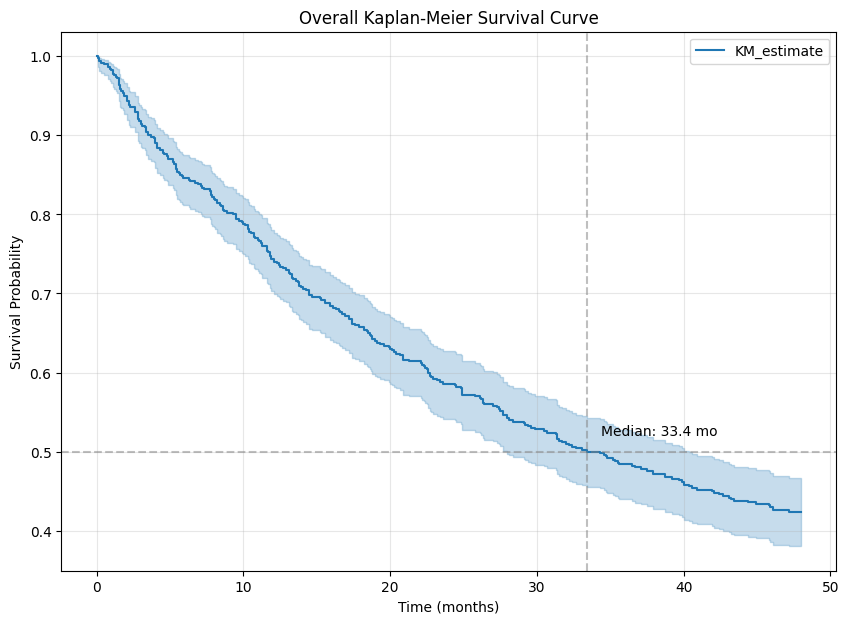

Median survival: 33.4 months


In [5]:
if HAS_LIFELINES:
    kmf = KaplanMeierFitter()
    kmf.fit(clinical_df['time_months'], event_observed=clinical_df['event'])

    fig, ax = plt.subplots(figsize=(10, 7))
    kmf.plot_survival_function(ax=ax, ci_show=True)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Survival Probability')
    ax.set_title('Overall Kaplan-Meier Survival Curve')
    ax.grid(True, alpha=0.3)

    median_surv = kmf.median_survival_time_
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(median_surv, color='gray', linestyle='--', alpha=0.5)
    ax.text(median_surv + 1, 0.52, f'Median: {median_surv:.1f} mo', fontsize=10)
    plt.show()

    print(f"Median survival: {median_surv:.1f} months")
else:
    # Manual KM implementation
    times = np.sort(clinical_df.loc[clinical_df['event']==1, 'time_months'].unique())
    survival = [1.0]
    for t in times:
        at_risk = (clinical_df['time_months'] >= t).sum()
        deaths = ((clinical_df['time_months'] == t) & (clinical_df['event'] == 1)).sum()
        survival.append(survival[-1] * (1 - deaths/at_risk))

    plt.figure(figsize=(10, 7))
    plt.step([0] + list(times), survival, where='post', color='steelblue', linewidth=2)
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.title('Kaplan-Meier Survival Curve (manual)')
    plt.grid(True, alpha=0.3)
    plt.show()

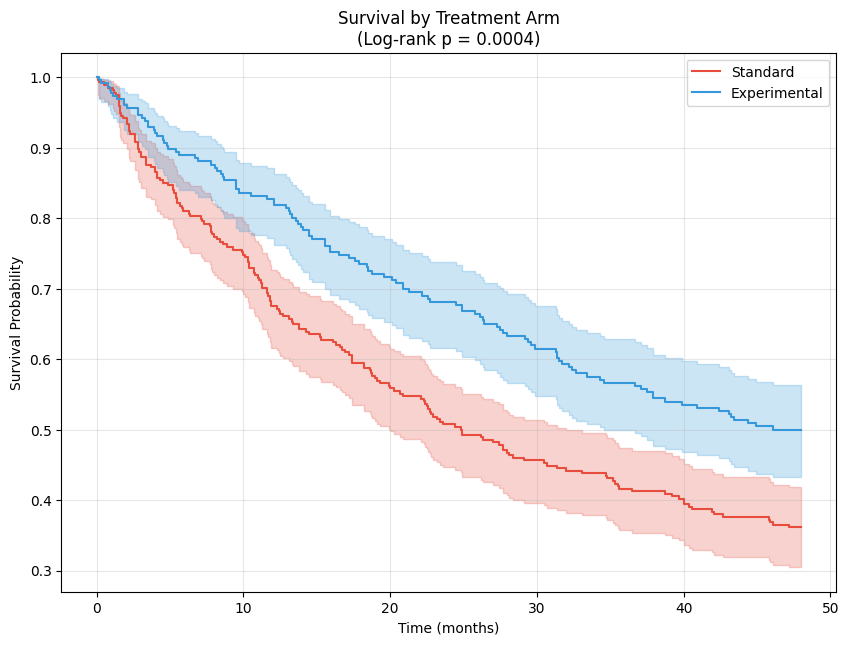

Log-rank test: chi2 = 12.55, p = 0.0004


In [6]:
if HAS_LIFELINES:
    fig, ax = plt.subplots(figsize=(10, 7))

    for name, color in [('Standard', '#e74c3c'), ('Experimental', '#3498db')]:
        mask = clinical_df['treatment'] == name
        kmf_arm = KaplanMeierFitter()
        kmf_arm.fit(clinical_df.loc[mask, 'time_months'],
                     event_observed=clinical_df.loc[mask, 'event'],
                     label=name)
        kmf_arm.plot_survival_function(ax=ax, ci_show=True, color=color)

    # Log-rank test
    std_mask = clinical_df['treatment'] == 'Standard'
    result = logrank_test(
        clinical_df.loc[std_mask, 'time_months'],
        clinical_df.loc[~std_mask, 'time_months'],
        event_observed_A=clinical_df.loc[std_mask, 'event'],
        event_observed_B=clinical_df.loc[~std_mask, 'event']
    )

    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Survival Probability')
    ax.set_title(f'Survival by Treatment Arm\n(Log-rank p = {result.p_value:.4f})')
    ax.grid(True, alpha=0.3)
    plt.show()

    print(f"Log-rank test: chi2 = {result.test_statistic:.2f}, p = {result.p_value:.4f}")
else:
    print("Install lifelines for KM comparison: pip install lifelines")

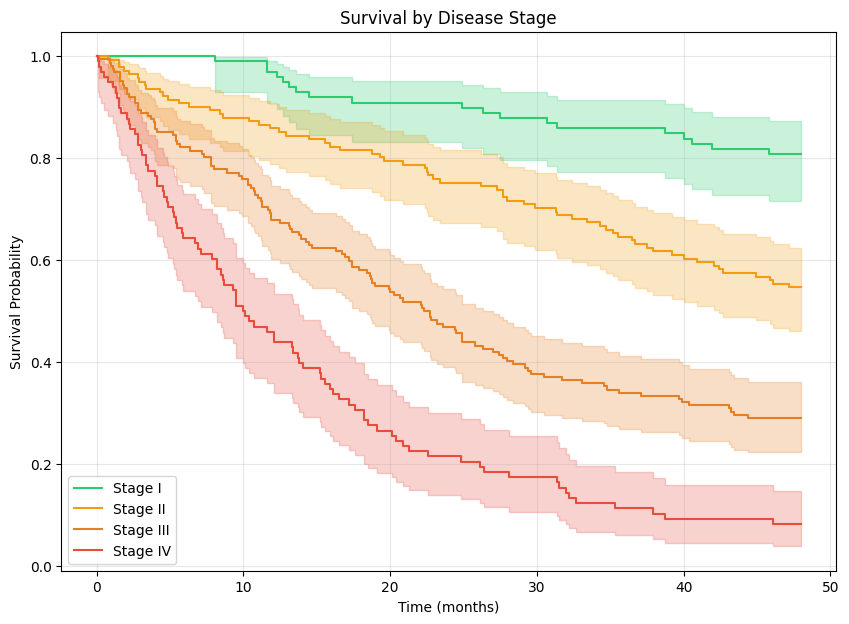

In [7]:
if HAS_LIFELINES:
    fig, ax = plt.subplots(figsize=(10, 7))
    colors_stage = {'I': '#2ecc71', 'II': '#f39c12', 'III': '#e67e22', 'IV': '#e74c3c'}

    for s in ['I', 'II', 'III', 'IV']:
        mask = clinical_df['stage'] == s
        kmf_stage = KaplanMeierFitter()
        kmf_stage.fit(clinical_df.loc[mask, 'time_months'],
                       event_observed=clinical_df.loc[mask, 'event'],
                       label=f'Stage {s}')
        kmf_stage.plot_survival_function(ax=ax, color=colors_stage[s])

    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Survival Probability')
    ax.set_title('Survival by Disease Stage')
    ax.grid(True, alpha=0.3)
    plt.show()
else:
    print("Install lifelines: pip install lifelines")

## Section 3: Cox Proportional Hazards

The Cox model relates covariates to hazard rate:

$$h(t|X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \ldots)$$

Key output: **hazard ratios** $\exp(\beta_i)$. HR > 1 means higher risk; HR < 1 means protective.

Reference [[Dose-Response Relationship]] -- Cox models quantify the dose-response
between risk factors and outcomes.

Reference [[Quality Control in Living Systems]] -- the Cox model reveals which biological
quality-control mechanisms (labs, biomarkers) predict system failure.

<lifelines.CoxPHFitter: fitted with 500 total observations, 212 right-censored observations>
             duration col = 'time_months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 288
   partial log-likelihood = -1588.04
         time fit was run = 2026-02-14 13:11:19 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
age           -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
bmi           -0.01      0.99      0.01           -0.03            0.02                0.97                1.02
biomarker      0.01      1.01      0.00            0.00            0.02                1.00                1.02
creatinine     0.12      1.13      0.19           -0.25            0.50                0.78                1.65
hemoglobin    -0.02      0.98      0.03           -0.08            0.04                0.93                1.04
stage_numeric  0.75      2.11      0.08            0.60            0.90                1.82                2.45
treatment_exp -0.55      0.58      0.12           -0.79           -0.31                0.45                0.73
sex_male      -0.01      0.99      0.12           -0.25            0.23                0.78                1.25

               cmp to     z      p  -log2(p)
covariate                                   
age              0.00 -0.41   0.68      0.55
bmi              0.00 -0.71   0.47      1.07
biomarker        0.00  2.15   0.03      4.98
creatinine       0.00  0.65   0.52      0.95
hemoglobin       0.00 -0.58   0.56      0.83
stage_numeric    0.00  9.87 <0.005     73.90
treatment_exp    0.00 -4.50 <0.005     17.18
sex_male         0.00 -0.08   0.94      0.09
---
Concordance = 0.74
Partial AIC = 3192.08
log-likelihood ratio test = 192.19 on 8 df
-log2(p) of ll-ratio test = 121.42

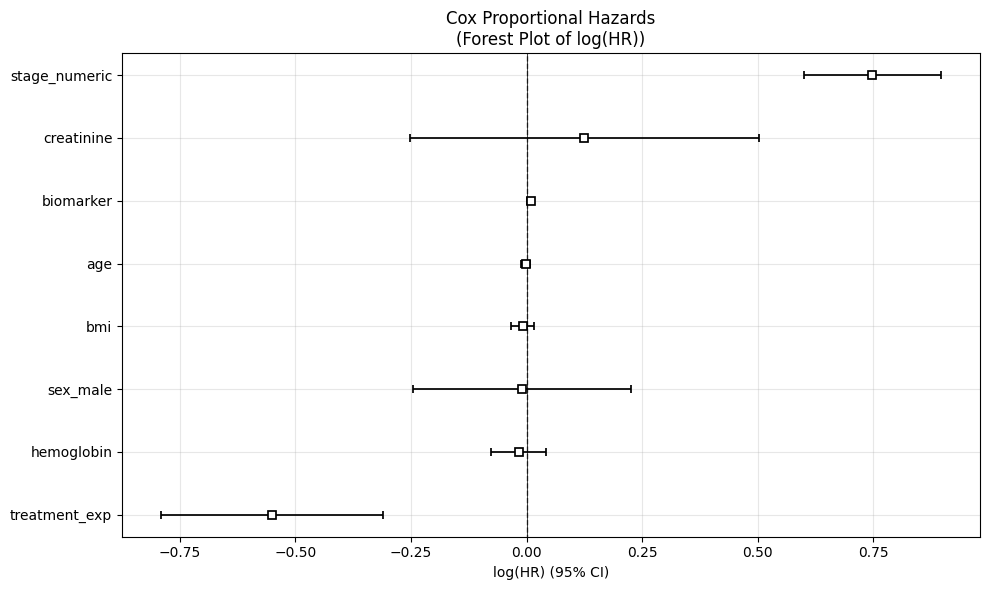

In [8]:
if HAS_LIFELINES:
    # Prepare data for Cox model
    cox_df = clinical_df[['time_months', 'event', 'age', 'bmi', 'biomarker', 'creatinine', 'hemoglobin']].copy()
    cox_df['stage_numeric'] = clinical_df['stage'].map({'I': 1, 'II': 2, 'III': 3, 'IV': 4})
    cox_df['treatment_exp'] = (clinical_df['treatment'] == 'Experimental').astype(int)
    cox_df['sex_male'] = (clinical_df['sex'] == 'M').astype(int)

    cph = CoxPHFitter()
    cph.fit(cox_df, duration_col='time_months', event_col='event')

    cph.print_summary()

    # Forest plot of hazard ratios
    fig, ax = plt.subplots(figsize=(10, 6))
    cph.plot(ax=ax)
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title('Cox Proportional Hazards\n(Forest Plot of log(HR))')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Install lifelines for Cox regression: pip install lifelines")

In [9]:
if HAS_LIFELINES:
    print(f"Concordance index: {cph.concordance_index_:.3f}")
    print(f"(0.5 = random, 1.0 = perfect discrimination)")
    print(f"\nSignificant predictors (p < 0.05):")
    sig_mask = cph.summary['p'] < 0.05
    for var in cph.summary[sig_mask].index:
        hr = np.exp(cph.summary.loc[var, 'coef'])
        p = cph.summary.loc[var, 'p']
        print(f"  {var}: HR = {hr:.2f}, p = {p:.4f}")
else:
    print("Skipping (lifelines not available)")

Concordance index: 0.735
(0.5 = random, 1.0 = perfect discrimination)

Significant predictors (p < 0.05):
  biomarker: HR = 1.01, p = 0.0317
  stage_numeric: HR = 2.11, p = 0.0000
  treatment_exp: HR = 0.58, p = 0.0000


## Section 4: Biomarker ROC Analysis

Can a biomarker predict outcomes? ROC (Receiver Operating Characteristic) analysis
evaluates discriminative ability. The AUC (area under the ROC curve) ranges from
0.5 (random) to 1.0 (perfect discrimination).

Reference [[Adaptive Response]] -- biomarkers reflect the body's adaptive response
to disease. Elevated biomarkers often signal that quality-control mechanisms
are under stress.

Reference [[Perturbation-Response-Adaptation]] -- a biomarker is the measurable
response to disease perturbation.

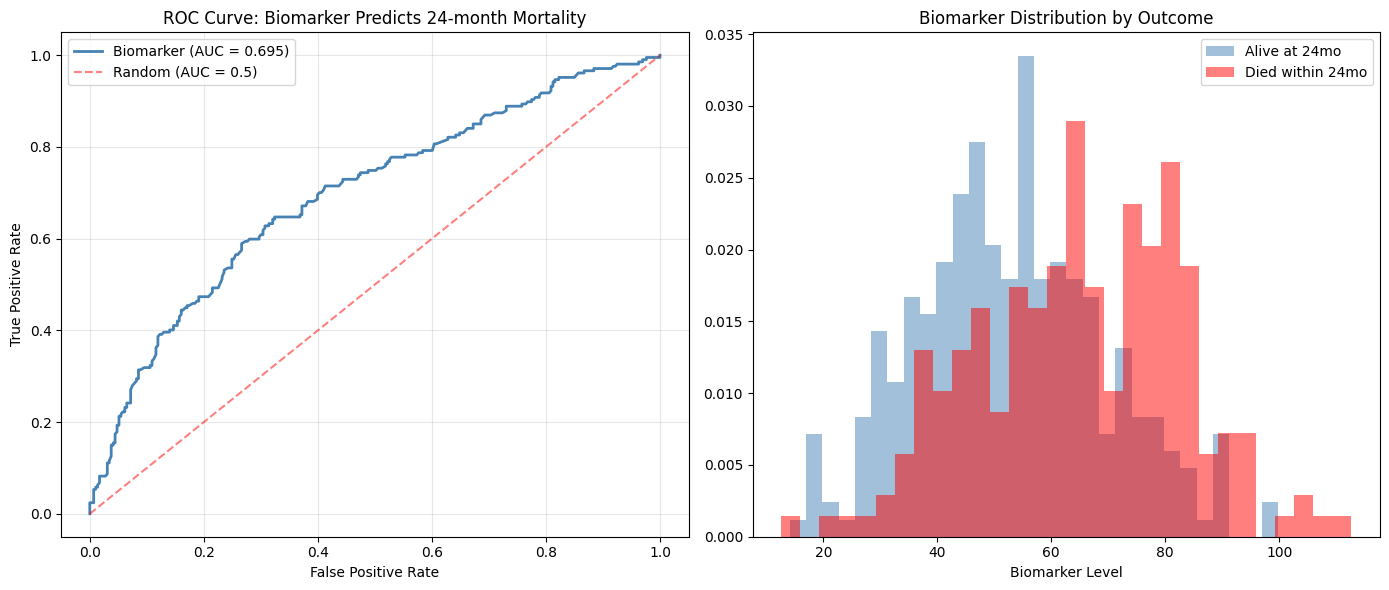

AUC = 0.695


In [10]:
# Binary outcome: event within 24 months?
y_true = ((clinical_df['time_months'] <= 24) & (clinical_df['event'] == 1)).astype(int)
y_score = clinical_df['biomarker']

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(fpr, tpr, color='steelblue', linewidth=2, label=f'Biomarker (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Random (AUC = 0.5)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve: Biomarker Predicts 24-month Mortality')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Biomarker distribution by outcome
ax2.hist(clinical_df.loc[y_true==0, 'biomarker'], bins=30, alpha=0.5, label='Alive at 24mo', color='steelblue', density=True)
ax2.hist(clinical_df.loc[y_true==1, 'biomarker'], bins=30, alpha=0.5, label='Died within 24mo', color='red', density=True)
ax2.set_xlabel('Biomarker Level')
ax2.set_title('Biomarker Distribution by Outcome')
ax2.legend()

plt.tight_layout()
plt.show()
print(f"AUC = {roc_auc:.3f}")

Optimal biomarker cutpoint: 62.5
  Sensitivity: 0.589
  Specificity: 0.734


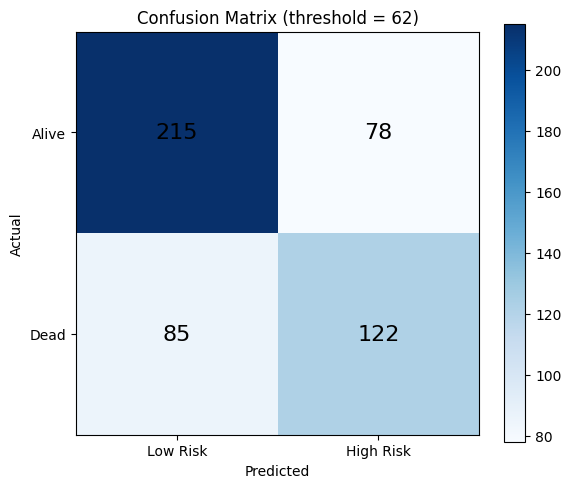

In [11]:
# Youden's index: optimal threshold = max(TPR - FPR)
youden = tpr - fpr
optimal_idx = np.argmax(youden)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal biomarker cutpoint: {optimal_threshold:.1f}")
print(f"  Sensitivity: {tpr[optimal_idx]:.3f}")
print(f"  Specificity: {1-fpr[optimal_idx]:.3f}")

# Apply threshold
predicted = (clinical_df['biomarker'] >= optimal_threshold).astype(int)
cm = confusion_matrix(y_true, predicted)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Low Risk', 'High Risk'])
ax.set_yticklabels(['Alive', 'Dead'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i,j]), ha='center', va='center', fontsize=16)
ax.set_title(f'Confusion Matrix (threshold = {optimal_threshold:.0f})')
plt.colorbar(im)
plt.tight_layout()
plt.show()

## Section 5: Simulated Clinical Trial

Clinical trial design requires balancing statistical power against practical constraints.
The key question: how many patients do we need to detect a treatment effect?

For a two-arm log-rank test, the required number of events depends on:
- **Hazard ratio**: smaller effects require more patients
- **Power**: higher power (probability of detecting a true effect) requires more patients
- **Significance level**: stricter alpha requires more patients

Reference [[Quality Control in Living Systems]] -- clinical trials are the quality-control
mechanism for medical interventions.

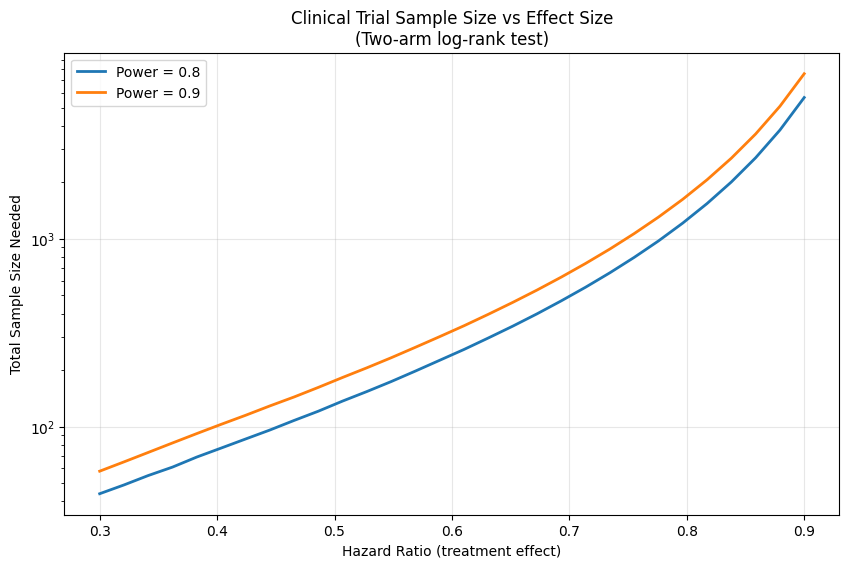

To detect HR = 0.6 with 80% power: N = 241 patients


In [12]:
# How many patients do we need to detect the treatment effect?
from scipy.stats import norm

def sample_size_logrank(hr, event_rate=0.5, alpha=0.05, power=0.8):
    """Sample size for log-rank test."""
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    d = ((z_alpha + z_beta) / np.log(hr))**2 * 4
    n = d / event_rate
    return int(np.ceil(n))

hrs = np.linspace(0.3, 0.9, 30)
powers = [0.8, 0.9]

plt.figure(figsize=(10, 6))
for pwr in powers:
    sizes = [sample_size_logrank(hr, power=pwr) for hr in hrs]
    plt.plot(hrs, sizes, linewidth=2, label=f'Power = {pwr}')

plt.xlabel('Hazard Ratio (treatment effect)')
plt.ylabel('Total Sample Size Needed')
plt.title('Clinical Trial Sample Size vs Effect Size\n(Two-arm log-rank test)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

hr_target = 0.6
n_needed = sample_size_logrank(hr_target)
print(f"To detect HR = {hr_target} with 80% power: N = {n_needed} patients")

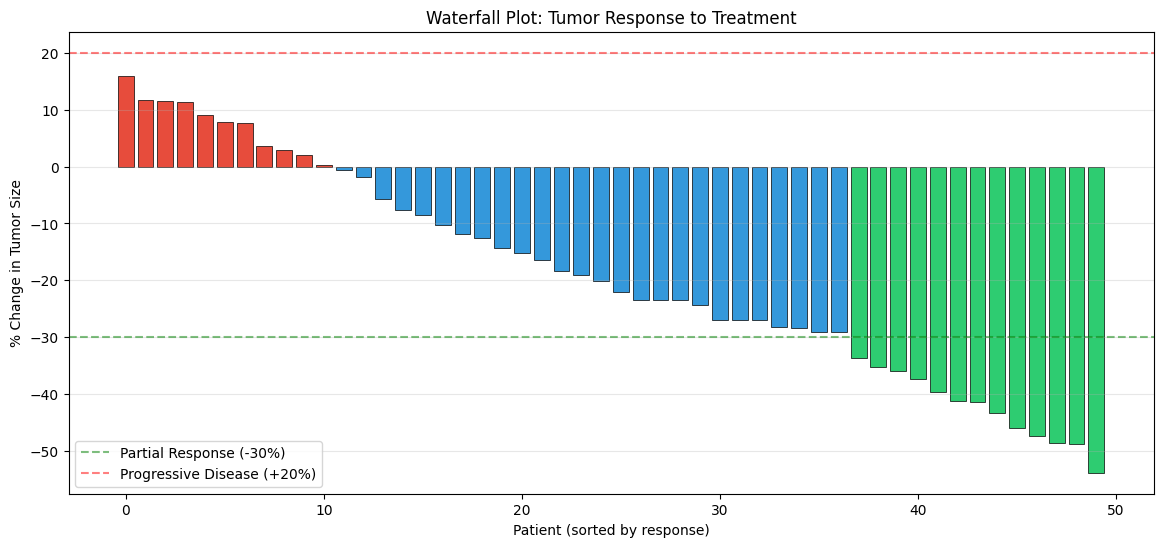

Partial Response: 13 (26%)
Stable Disease: 37 (74%)
Progressive Disease: 0 (0%)


In [13]:
# Waterfall plot (tumor response per patient)
np.random.seed(42)
n_trial = 50
responses = np.concatenate([
    np.random.normal(-20, 15, 35),  # Most patients: some tumor shrinkage
    np.random.normal(10, 8, 10),    # Some patients: tumor growth
    np.random.normal(-45, 5, 5),    # A few complete responders
])
np.random.shuffle(responses)
responses = np.clip(responses, -100, 50)

# Sort by response
sorted_resp = np.sort(responses)[::-1]

colors_wf = ['#2ecc71' if r <= -30 else '#3498db' if r <= 0 else '#e74c3c' for r in sorted_resp]

plt.figure(figsize=(14, 6))
plt.bar(range(len(sorted_resp)), sorted_resp, color=colors_wf, edgecolor='black', linewidth=0.5)
plt.axhline(-30, color='green', linestyle='--', alpha=0.5, label='Partial Response (-30%)')
plt.axhline(20, color='red', linestyle='--', alpha=0.5, label='Progressive Disease (+20%)')
plt.xlabel('Patient (sorted by response)')
plt.ylabel('% Change in Tumor Size')
plt.title('Waterfall Plot: Tumor Response to Treatment')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

pr = (sorted_resp <= -30).sum()
sd = ((sorted_resp > -30) & (sorted_resp <= 20)).sum()
pd_count = (sorted_resp > 20).sum()
print(f"Partial Response: {pr} ({pr/len(sorted_resp):.0%})")
print(f"Stable Disease: {sd} ({sd/len(sorted_resp):.0%})")
print(f"Progressive Disease: {pd_count} ({pd_count/len(sorted_resp):.0%})")

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| Clinical data | Structured patient cohort | EHR data analysis foundation |
| Kaplan-Meier | Survival curves with censoring | Standard oncology endpoint |
| Cox PH | Multivariate hazard model | [[Dose-Response Relationship]] quantification |
| Log-rank test | Treatment arm comparison | Clinical trial primary endpoint |
| ROC analysis | Biomarker discrimination | Diagnostic test evaluation |
| Power analysis | Sample size calculation | Trial design |
| Waterfall plot | Individual patient response | Treatment efficacy visualization |

**Connections to conceptual framework:**
- [[Trajectory in State Space]]: Patient clinical course as state-space trajectory
- [[Dose-Response Relationship]]: Cox hazard ratios quantify risk-factor dose-response
- [[Adaptive Response]]: Biomarkers reflect adaptive stress response
- [[Context Conditionality]]: Same lab value, different meaning per patient context
- [[Perturbation-Response-Adaptation]]: Disease as perturbation, treatment as counter-perturbation
- [[Quality Control in Living Systems]]: Clinical trials as QC for interventions

**Next**: [[07_Biomedical_Image_Analysis]] -- pathology and radiology image analysis